### Imports, plot configuration

In [8]:
# ------------------------------------------------------------------------
# Library imports
# ------------------------------------------------------------------------

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# ------------------------------------------------------------------------
# Global plotting configuration
# ------------------------------------------------------------------------
# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

### Fetch data from nerd sqlite database

In [9]:
def fetch_timecourse_data(db_path, selected_rg_id, selected_site_base, selected_valtype_tc):
    """
    Fetch time-course data for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    selected_rg_id : int
        Reaction group ID to filter by.
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').
    
    Returns
    -------
    pd.DataFrame
        DataFrame containing timecourse data with columns: rg_id, reaction_time,
        treated, temperature, replicate, buffer_id, fmod_val, valtype, site,
        base, site_base, and sample_name.
    """

    conn = sqlite3.connect(db_path)
    timecourse_df = pd.read_sql_query(
        """
        SELECT
            pr.rg_id,
            pr.reaction_time,
            pr.treated,
            pr.temperature,
            pr.replicate,
            pr.buffer_id,
            fv.fmod_val,
            fv.valtype,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base,
            s.sample_name
        FROM probe_reactions pr
        JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        WHERE pr.rg_id = :rg_id
        AND mn.site || '_' || UPPER(mn.base) = :site_base
        AND fv.valtype = :valtype
        AND s.to_drop != 1
        AND fv.outlier != 1
        ORDER BY pr.reaction_time
        """,
        conn,
        params={"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype": selected_valtype_tc},
    )
    conn.close()

    return timecourse_df

In [10]:
def fetch_tc_fit_params(db_path, selected_rg_id, selected_site_base, selected_valtype_tc):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_rg_id : int
        Reaction group ID to filter by.
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    fitted_params_df = pd.read_sql_query(
        """
        WITH run AS (
        SELECT id AS fit_run_id
        FROM probe_tc_fit_runs
        WHERE (rg_id, nt_id) IN (
            SELECT DISTINCT pr.rg_id, mn.id
            FROM probe_reactions pr
            JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
            JOIN meta_nucleotides mn ON mn.id = fv.nt_id
            WHERE pr.rg_id = :rg_id
            AND mn.site || '_' || UPPER(mn.base) = :site_base
        )
        AND fit_kind = 'round3_constrained'
        AND valtype = :valtype_mod
        )
        SELECT
        p.fit_run_id,
        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')    THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')    THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')  THEN p.param_numeric END) AS log_fmod0,
        MAX(CASE WHEN p.param_name =  'kobs'                    THEN p.param_numeric END) AS kobs,
        MAX(CASE WHEN p.param_name =  'kdeg'                    THEN p.param_numeric END) AS kdeg,
        MAX(CASE WHEN p.param_name =  'fmod0'                   THEN p.param_numeric END) AS fmod0,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')    THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')    THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')  THEN p.param_numeric END) AS log_fmod0_err,
        MAX(CASE WHEN p.param_name =  'diag:r2'                 THEN p.param_numeric END) AS diag_r2
        FROM probe_tc_fit_params p
        JOIN run r ON r.fit_run_id = p.fit_run_id
        GROUP BY p.fit_run_id
        """,
        conn,
        params={"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )
    conn.close()
    return fitted_params_df

In [11]:
def _fmod_model(x: np.ndarray, log_kappa: float, log_kdeg: float, log_fmod_0: float) -> np.ndarray:
    """ PRIME kinetic equation """

    kappa = np.exp(log_kappa)     # == kobs
    kdeg  = np.exp(log_kdeg)
    fmod0 = np.exp(log_fmod_0)
    return 1.0 - np.exp(-kappa * (1.0 - np.exp(-kdeg * x))) + fmod0

def plot_timecourse(db_path, selected_rg_id, selected_site_base, selected_valtype_tc, ax):
    """Plot timecourse data and fitted curve for a given reaction group and nucleotide."""

    # Fetch timecourse data
    timecourse_df = fetch_timecourse_data(db_path, selected_rg_id, selected_site_base, selected_valtype_tc)

    # Fetch fitted parameters
    fit_params_df = fetch_tc_fit_params(db_path, selected_rg_id, selected_site_base, selected_valtype_tc)

    if timecourse_df.empty:
        print("No timecourse rows matched those filters.")
    else:
        # Set untreated reaction_time to zero
        timecourse_df['reaction_time'] = timecourse_df['reaction_time'] * timecourse_df['treated']
        
        # Adjust fmod_val to percent and reaction time to hr^-1
        ax.scatter(timecourse_df["reaction_time"] / 3600., timecourse_df["fmod_val"] * 100., label=selected_site_base, s = 10)

        # Build and add fitted curve if params exist
        if len(fit_params_df) >0:
            # choose best run if multiple (highest R^2)
            best = fit_params_df.sort_values("diag_r2", ascending=False).iloc[0]
            log_kobs  = float(best["log_kobs"])
            log_kdeg  = float(best["log_kdeg"])
            log_fmod0 = float(best["log_fmod0"])

            # x_fit domain from observed times (fall back to 0..max if needed)
            x_min = 0.0
            x_max = float(timecourse_df["reaction_time"].max())
            if x_min == x_max:
                x_min, x_max = 0.0, max(1.0, x_max)

            x_fit = np.linspace(x_min, x_max, 200)
            y_fit = _fmod_model(x_fit, log_kobs, log_kdeg, log_fmod0)

            ax.plot(x_fit / 3600., y_fit * 100., linewidth=1)

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles=handles, labels=labels, loc="best")
            
    return timecourse_df, fit_params_df, ax

18_A -2.7629725710698203 -8.407162121069696
9_C -4.246217584653951 -8.407162121069696
8_A -3.708979684431496 -8.407162121069696
7_A -3.798009849800944 -8.407162121069696
22_A -4.5204468990672275 -8.407162121069696
35_A -4.569718998514919 -8.407162121069696
15_A -4.878999375478776 -8.407162121069696
16_A -5.145277839213481 -8.407162121069696
26_A -5.291885476115227 -8.407162121069696
29_A -5.357994531206083 -8.407162121069696


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


34_A -4.80181516561843 -8.407162121069696
25_C -6.546861536982164 -8.407162121069696


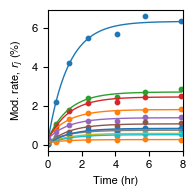

In [13]:
# Database path
NERD_SQLITE = '../../../Core_nerd_analysis/nerd.sqlite'

# fourU WT at 25°C
selected_rg_id = 80

collapse_data = []

fig, ax = plt.subplots(figsize=(2, 2))

for site_nt in ['18_A', '9_C', '8_A', '7_A', '22_A', '35_A', '15_A', '16_A', '26_A', '29_A', '34_A', '25_C']:
    tc, fit, ax = plot_timecourse(NERD_SQLITE, selected_rg_id, site_nt, 'modrate', ax)
    print(site_nt, fit['log_kobs'].values[0], fit['log_kdeg'].values[0])

ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'Mod. rate, $r_j$ (%)')

# set x lim 0 to 8, tick every 2
ax.set_xlim(0, 8)
ax.set_xticks(np.arange(0, 9, 2))

# legend outside on the right
#ax.legend(frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))

# no legend
ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig('4U_wt_representative_fits.pdf')
plt.show()